# Developmental modeling of maracuyá (*Passiflora*) leaf shape using high-resolution pseudo-landmarks

______

The following is a `jupyter notebook` ([Kluyver et al. 2016](https://ebooks.iospress.nl/doi/10.3233/978-1-61499-649-1-87)) tutorial written using the `python` coding language. Text written in `markdown cells` is used to explain code presented and executed in `coding cells`. This tutorial assumes a working knowledge of `python` and the ability to use `jupyter notebooks`.  

If you are new to `python` or do not know how to use `jupyter notebooks`, we recommend that you familiarize yourself with them through a tutorial. For the context of plant biology and leaf shape presented here, we recommend `Plants&Python` ([VanBuren et al., 2022](https://doi.org/10.1093/plcell/koac187)), accessible using this [link](https://plantsandpython.github.io/PlantsAndPython). There you will find instructions for downloading and installing [Anaconda](https://docs.anaconda.com/anaconda/install/) and how to get going with `jupyter notebooks` and `python`.

### Import modules

We first import modules which contain functions and other code necessary to perform the analysis in this `jupyter notebook`.

Below, we provide references for some of the modules used in this notebook:  

- `pandas`, [McKinney, 2010](http://conference.scipy.org.s3.amazonaws.com/proceedings/scipy2010/pdfs/mckinney.pdf)
- `numpy`, [Harris et al., 2020](https://www.nature.com/articles/s41586-020-2649-2)
- `matplotlib`, [Hunter, 2007](https://www.computer.org/csdl/magazine/cs/2007/03/c3090/13rRUwbJD0A)
- `scikit-learn`, [Pedregosa et al., 2011](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/)
- `scipy`, [Virtanen et al., 2020](https://www.nature.com/articles/s41592-019-0686-2)
- `seaborn`, [Waskom, 2021](https://joss.theoj.org/papers/10.21105/joss.03021.pdf)
- `opencv`, [Bradski and Kaehler, 2008](https://books.google.com/books?hl=en&lr=&id=seAgiOfu2EIC&oi=fnd&pg=PR3&dq=learning+openCV&ots=hWF7cgcJTc&sig=xmdPQz_61cYPjdKQ8mEnJk0Q2-0#v=onepage&q=learning%20openCV&f=false)
- `phate`, [Moon et al., 2019](https://www.nature.com/articles/s41587-019-0336-3)
- `umap`, [McInnes, Healy, and Melville, 2018](https://arxiv.org/abs/1802.03426)

In [1]:
import os # for retrieving files from directory
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import numpy as np # for working with arrays and other functions
import matplotlib.pyplot as plt # for plotting and visualization
import matplotlib as mpl # for plotting and visualization
import cv2 # for image analysis. to install on mac: pip install opencv-python
import pandas as pd # for working with dataframes
from sklearn.decomposition import PCA # for principal component analysis
from scipy.interpolate import interp1d # for interpolating points
import math # for mathematical operations
from scipy.spatial import ConvexHull # for convex hull
from scipy.spatial import procrustes # for Procrustes analysis
import seaborn as sns # for plotting in seaborn
import matplotlib.cm as cm # for setting color palettes
from matplotlib.colors import Normalize # for setting color palettes
import phate # for using PHATE # pip install --user phate
import scprep # for using PHATE
import umap # for using UMAP # install umap-learn, not umap!! # pip uninstall umap # pip install umap-learn
from sklearn.manifold import TSNE # for using TSNE

### Define functions

The following functions define useful operations used in the analysis.

In [2]:

#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated x and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


### Rationale and data sources

To demonstrate how to create continuous models of leaf shape across development (specifically, nodes in a shoot) we used previously colelcted leaves from maracuyá (we use here the Hispanicized version of the Indigenous name for *Passiflora*). This data was specifcally collected for creating developmental models, which have been previously published, but that we revisit here using a high-resolution pseudo-lanmdark approach for the first time. The data was first published comparing landmark and elliptical Fourier approaches ([Chitwood and Otoni, 2017a](https://academic.oup.com/gigascience/article/6/1/giw008/2865207)) and comparing leaves across the heterblastic series, hypothesizing that juvenile leaves arise from a common shape space that diverge into adult morphologies ([Chitwood and Otoni, 2017b](https://onlinelibrary.wiley.com/doi/full/10.1002/pld3.28)). Recently, revisting the maracuyá data, we sought to represent heteroblastic leaf development from the perspective of a mapper graph, a topological data analysis technique that represents underlying data structures viewed through a lens function as a graph ([Percival, Onyenedum, Chitwood, Husbands, 2024](https://journals.plos.org/ploscompbiol/article?id=10.1371%2Fjournal.pcbi.1011845)). From the originally, published image and contour data ([Chitwood and Otoni, 2016](http://dx.doi.org/10.5524/100251)) the data has been converted into numpy arrays as `.npy` files in the folder `Passiflora` from [Wang, Willey, and Chitwood, 2024](https://doi.org/10.6084/m9.figshare.25435936.v1). **In order to perform this analysis, you must download the folder `Passiflora` from [Wang, Willey, and Chitwood, 2024](https://doi.org/10.6084/m9.figshare.25435936.v1) and place the folder in the current working directory.** Leaf `.npy` files are named by species, numbered sequentially for each separate plant sampled, followed by the node position counting upwards from the tip. Landmarks for the tip and base of each leaf (`landmarks.csv`) were used for orientation to place pesudo-landmarks and merged with morphotype information for each species (`morphotypes.csv`).

### Create binary image files

The `.npy` leaf contour files do not have orientation. We need tip and base indices along the outline to accurately place pseudo-landmarks using our method. To do this, a binary image was created for each `.npy` file and saved. Each of these images was manually landmarked for base and tip coordinates using the image analysis software FIJI ([Schindelin et al., 2012](https://www.nature.com/articles/nmeth.2019)) and stored in the file `landmarks.csv`.

In [6]:
data_dir = "./Passiflora/" # set the directory for .npy contours for each leaf

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
#file_names.remove('.DS_Store') # remove .DS_Store file
file_names.sort() # sort the list of file names

# set a directory to store binary images
binary_images_dir = os.path.join('binary_images/')

# if the folder doesn't exist already, create it
if not os.path.isdir(binary_images_dir):
    os.makedirs(binary_images_dir)

# for each numpy file
for i in range(len(file_names)):
    
    if i%500==0: # print every 500th file
        print(i)

    curr_file = file_names[i] # the current npy file
    lf = np.load(data_dir + curr_file) # load in the file

    plt.fill(lf[:,0], lf[:,1], c="k") # plot a binary leaf image and save
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.savefig(binary_images_dir+curr_file[:-4]+".png")
    plt.close()

0
500
1000
1500
2000
2500
3000


### Calculating pseudo-landmarks

Before pseudo-landmarks are calculated, different parameters are provided. An arbitrarily high number of points (in this case, `10,000`) is defined to first place this number of equidistant points around the original contour, in which the number of points is originally arbitrary and they are not equidistantly placed. A list of problem files to skip is provided. Most importantly, the final resolution `res`, the final number of pseudo-landmarks, is defined. The resolution is roughly the number of equidistant points on each side of the leaflet. In this case, the resolution is `50`, which yields `99` (or `res*2-1`) final pseudo-landmarks, in which the index of the tip of the leaf is `res-1` and the index of the base is `0`. The final number of pseudo-landmarks is not simply twice the resolution because the tip point is placed twice for each side, and one point is removed to avoid redundancy. The species, plant, and node identity for each leaf is extracted from the file name, and the morphotype associated with each cross-referenced with species identity using the file `morphotypes.csv`. The species, plant, node, and morphotype identities are afterwards combined together into a `pandas` dataframe. The dataframe is used to index the pseudo-landmark data. Leaves are oriented using the base and tip indices. Using the high-resolution interpolation of the contour, the indices of the tip and base are calculated and the base index set to `0`. The resolution value `res` is then used to place the desired number of equidistant pseudo-landmarks on each side of the leaf, taking care to remove the duplicate point at the tip. Finally, leaflets are rotated so that the tip points upward for aesthetic purposes.

In [3]:
#############################
### READ IN LANDMARK DATA ###
#############################

land_df = pd.read_csv("./landmarks.csv") # read in csv of base/tip landmarks
morpho_df = pd.read_csv("./morphotypes.csv") # read in csv of morphotype info
lf_files = land_df["file"].unique() # create a list of unique file names

######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (res-1 for the index of the tip, 0 for the index of the base)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
res = 50 ########
#################
#################

# get information for each file
file_paths = [] # to store file path info
plant_list = [] # to store plant identity
spe_list = [] # to store species identity
node_list = [] # store node identity

# an array to store pseudo-landmarks
data_arr = np.zeros((len(lf_files),(res*2)-1,2))

counter = 0 

for i in range(len(lf_files)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = lf_files[i] # get current file name

    if i%500==0: # print every 500th i
        print(i)

    # store file path, plant, species, and node identities
    file_paths.append(name)
    plant_list.append(land_df[(land_df["file"]==name)].iloc[0,5])
    spe_list.append(land_df[(land_df["file"]==name)].iloc[0,6])
    node_list.append(land_df[(land_df["file"]==name)].iloc[0,7])

    # read in image
    # convert to grayscale
    # invert the binary
    
    image_path = "./binary_images/" + name
    
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    xvals = sorted_x_conts[0] # get the contour x vals
    yvals = sorted_y_conts[0] # get the contour y vals
    
    ################################################
    ### ORIENT LEAF AND FIND BASE AND TIP POINTS ###
    ################################################
    
    # create leaf coordinates
    # convert array to float
    lf = np.transpose(np.array([xvals, yvals])).astype(np.float32)
    
    # retrieve base and tip points of the contour
    base_x = land_df["x"][(land_df["file"]==name)][(land_df["base_tip"]=="base")].item()
    base_y = land_df["y"][(land_df["file"]==name)][(land_df["base_tip"]=="base")].item()

    tip_x = land_df["x"][(land_df["file"]==name)][(land_df["base_tip"]=="tip")].item()
    tip_y = land_df["y"][(land_df["file"]==name)][(land_df["base_tip"]=="tip")].item()

    base_pt = np.array([base_x, base_y])
    tip_pt = np.array([tip_x, tip_y])

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(lf[:,0], 
                                           lf[:,1], high_res_pts)
    
    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)
    
    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaflet coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))
    
    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))
    
    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # store the leaflet into data_arr
    data_arr[counter,:,:] = rot_pts
    
    counter+=1
    
#########################################
### COMBINE METADATA INTO A DATAFRAME ###
#########################################
    
# create a pandas dataframe
mdata = pd.DataFrame({
    "file":file_paths,
    "plant":plant_list,
    "species":spe_list,
    "node":node_list
})

# merge with morphotype info
mdata = mdata.merge(morpho_df, "left")


0
500
1000
1500
2000
2500
3000


### Generalize Procrustes analysis (GPA)

Procrustean alignment was use to superimpose leaves to a common mean. To superimpose contours from each group by minimizing the overall distance between pseudo-landmark values through the functions of translation, scaling, rotation, and reflection, a generalized Procrustes analysis (GPA) is used ([Gower, 1975](https://link.springer.com/article/10.1007/BF02291478)). A function was defined to calculate a GPA mean. To calculate the GPA mean, an arbitrary leaflet is first chosen and all other leaflets are aligned to it using Procrustean superimposition. A mean from the aligned shapes is calculated, which is used as the reference shape for alignment in the next iteration. The algorithm stops when the Procrustes distance between means calculated between two successive iterations falls below an arbitrarily low value. All leaflets are then aligned to the final GPA mean shape. The Procrustean superimposition of each leaflet type was visualized by plotting each leaflet with high transparency together with its respective mean.

(-0.17791003450303253,
 0.1731857820567658,
 -0.16629088627865193,
 0.18705740197293613)

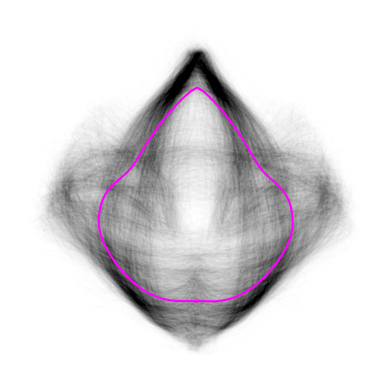

In [4]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(data_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(data_arr)) 

for i in range(len(data_arr)):
    s1, s2, distance = procrustes(mean_shape, data_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    
########################
### VISUALIZE LEAVES ###
########################

for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.005)
    
plt.plot(mean_shape[:,0], mean_shape[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")

### Morphospace

A morphospace was created and visualized using principal component analysis (PCA) and the inverse PCA transform. To determine the variance associated with each principal component (PC), PCA was first performed with the maximum number of PCs, which in this case is twice the pseudo-landmark number (the number of coordinate values). PCA was fitted again using only 2 PCs for simplicity of morphospace visualization. Along regular intervals of PC1 and PC2 the inverse transform was used to visualize representative leaves, or so-called `eigenleaves`. Data was projected back onto the calcualted PCA and morphospace.

In [5]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = (2*res-1)*2 # PC number = number of pseudo-landmarks
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

PC: var, overall 
PC1: 56.4%, 56.4%
PC2: 24.6%, 81.0%
PC3: 7.4%, 88.4%
PC4: 3.7%, 92.1%
PC5: 2.1%, 94.2%
PC6: 1.1%, 95.3%
PC7: 0.7%, 96.0%
PC8: 0.6%, 96.6%
PC9: 0.6%, 97.1%
PC10: 0.5%, 97.7%
PC11: 0.4%, 98.0%
PC12: 0.3%, 98.3%
PC13: 0.3%, 98.6%
PC14: 0.2%, 98.8%
PC15: 0.2%, 98.9%
PC16: 0.1%, 99.0%
PC17: 0.1%, 99.1%
PC18: 0.1%, 99.2%
PC19: 0.1%, 99.3%
PC20: 0.1%, 99.3%
PC21: 0.1%, 99.4%
PC22: 0.0%, 99.4%
PC23: 0.0%, 99.5%
PC24: 0.0%, 99.5%
PC25: 0.0%, 99.6%
PC26: 0.0%, 99.6%
PC27: 0.0%, 99.6%
PC28: 0.0%, 99.6%
PC29: 0.0%, 99.7%
PC30: 0.0%, 99.7%
PC31: 0.0%, 99.7%
PC32: 0.0%, 99.7%
PC33: 0.0%, 99.7%
PC34: 0.0%, 99.8%
PC35: 0.0%, 99.8%
PC36: 0.0%, 99.8%
PC37: 0.0%, 99.8%
PC38: 0.0%, 99.8%
PC39: 0.0%, 99.8%
PC40: 0.0%, 99.8%
PC41: 0.0%, 99.8%
PC42: 0.0%, 99.8%
PC43: 0.0%, 99.8%
PC44: 0.0%, 99.9%
PC45: 0.0%, 99.9%
PC46: 0.0%, 99.9%
PC47: 0.0%, 99.9%
PC48: 0.0%, 99.9%
PC49: 0.0%, 99.9%
PC50: 0.0%, 99.9%
PC51: 0.0%, 99.9%
PC52: 0.0%, 99.9%
PC53: 0.0%, 99.9%
PC54: 0.0%, 99.9%
PC55: 0.0%, 99.9%

In [6]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # PC number = 2, for limiting to 2 axes for morphospace reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]

PC: var, overall 
PC1: 56.4%, 56.4%
PC2: 24.6%, 81.0%


Text(0.5, 1.0, 'Procrustean morphospace')

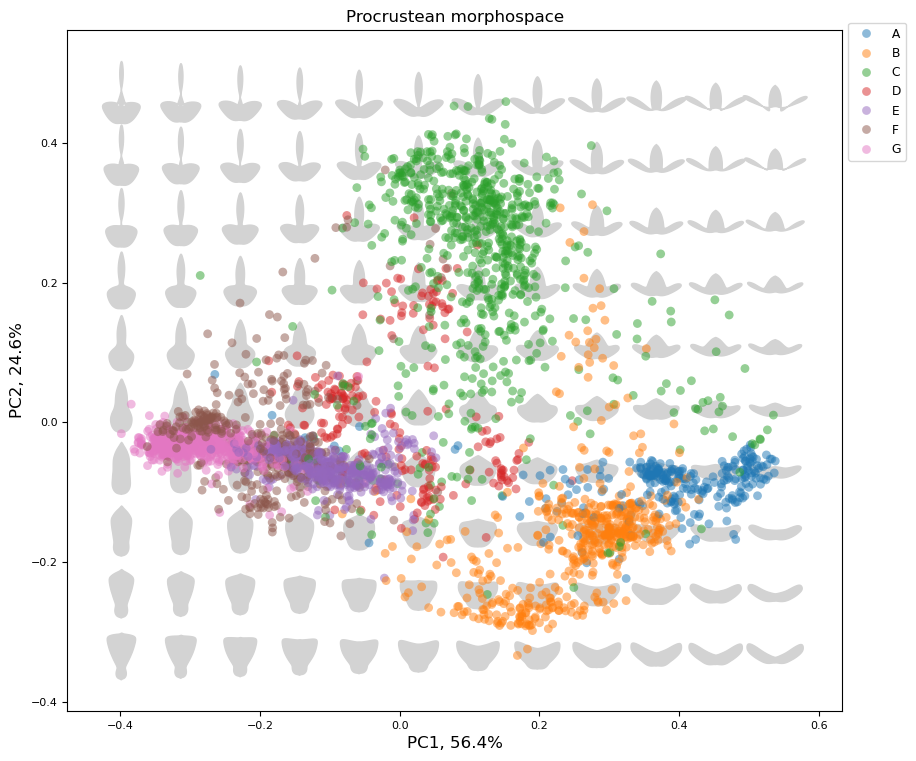

In [7]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 12 # set number of PC1 intervals
numPC2 = 10 # set number of PC2 intervals
hue = "morphotype" # select the factor to color by
s = 0.25 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 1 # alpha of inverse eigenleaf
pt_size = 40 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.5 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, 
                x="PC1", y="PC2", 
                hue=hue, 
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, 
                linewidth=pt_linewidth, 
                alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(False)
plt.gca().set_axisbelow(True)
plt.title(title)

### Developmental models

The maracuyá dataset presented here represents leaf series: all the mature leaves of a single plant were sampled across nodes, from tip to base. Previously we created continuous developmental models of leaves by node in grapevine, with both a low number ([Bryson et al., 2020](https://bsapubs.onlinelibrary.wiley.com/doi/10.1002/aps3.11404)) and high number ([Chitwood et al., 2024](https://nph.onlinelibrary.wiley.com/doi/10.1002/ppp3.10561)) of pseudo-landmarks. To create similar models here, for each `x` and `y` coordinate for each pseudo-landmark, we model values continuously as a function of node using 2nd degree polynomial models. Node is numbered from the tip counting upwards towards the base. To normalize for variable numbers of nodes between plants, we divide node by the maximum node value to create the variable `relative node`, which converts the shoot to a continuous 0 to 1 range, where 0 represents the tip and 1 the base of the shoot. To avoid extrapolating our models, we begin and end our models with the first and last empirically measured leaves. The collection of resulting 2nd degree polynomial models can be used to visualize theoretical leaves and the leaf series as the whole. For subsequent analysis, we use a set number of intervals across the modeled range so that we can compare leaf models using modeled coordinate values. Averages of models for each species were taken and visualized as the same number of intervals across the developmental series and colored by morphotype.

In [8]:
intervals = 40 # set number of intervals over nodes to model
poly_order = 2 # set poly order
#xvals = np.linspace(0,1,intervals) # x vals to model over
total_length = np.shape(proc_arr)[1] # number of landmarks to consider
plants = mdata["plant"].unique() # get the plant names to model
pd.options.mode.chained_assignment = None  # default='warn'

# create array to store models
leaf_model_arr = np.zeros( ((len(plants), # number of plants
                             intervals, # number of intervals
                             total_length, # number of landmarks
                             2))) # number of coordinates

# create list to store species identity
spe_list = []

# create list to store morphotype identity
morpho_list = []
                           
for p in range(len(plants)): # for each plant

    # get dataframe for current plant
    curr_plant = mdata[mdata["plant"]==plants[p]] 
    
    # store species and morphotype info
    spe_list.append(curr_plant["full_name"].iloc[0])
    morpho_list.append(curr_plant["morphotype"].iloc[0])

    # get indices of current plant
    plant_inds = curr_plant.index 

    # get max node number
    max_node = curr_plant["node"].max() 

    # create relative node
    curr_plant["rel_node"] = curr_plant["node"]/curr_plant["node"].max()

    # an array to hold the  modeled data
    model_arr = np.zeros((intervals,total_length,2))

    for i in range(total_length): # for i landmark 

        for j in range(2): # for j coordinates in x and y, 0 and 1

            # fit function across relative node values for current i, j landmark coord val
            N = np.polyfit( np.array(curr_plant["rel_node"]), proc_arr[plant_inds, i, j], poly_order)
            func = np.poly1d(N)
            
            # model over minimum to max relative node numbers
            xvals = np.linspace(curr_plant["rel_node"].min(),
                        curr_plant["rel_node"].max(),
                        intervals)

            # model vals over desired xvals, 0 to 1
            model_vals = func(xvals)

            # place modeled values into array
            model_arr[0:intervals, i, j] = model_vals
    
    # save model to array
    leaf_model_arr[p,:,:,:] = model_arr
    
# create df for model identities
model_df = pd.DataFrame({"species":spe_list,
                         "morpho":morpho_list})


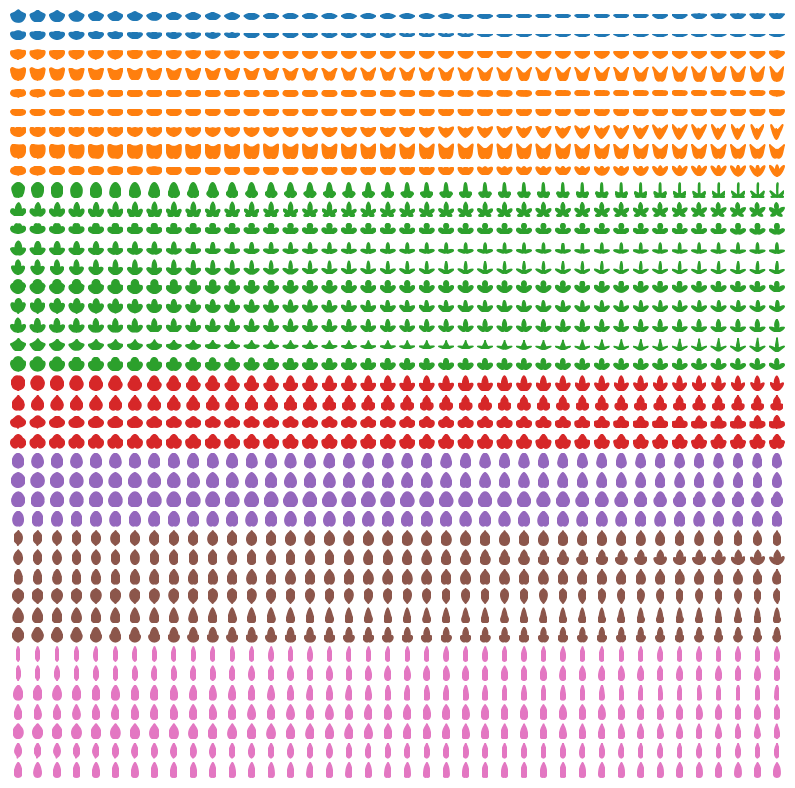

In [9]:
plt.figure(figsize=(10,10))

counter = 1

for m in range(7): # for each of 7 morphotypes
    
    # get dataframe for current morphotype
    curr_morpho = model_df[model_df["morpho"]==[" A"," B"," C"," D"," E"," F"," G"][m]]
    
    # get the current color
    curr_col = sns.color_palette()[m]
    
    for s in range(len(curr_morpho["species"].unique())): # for each species in that morphotype

        # get the current species for the morphotype
        curr_spe = curr_morpho[curr_morpho["species"]==curr_morpho["species"].unique()[s]]
        
        # get the indices for the current species
        spe_inds = np.array(curr_spe.index)
        
        # get the coordinates for the current species
        spe_arr = leaf_model_arr[spe_inds]
        
        # calculate mean model for the current species
        mean_spe = np.mean(spe_arr, axis=0)
        
        for i in range(intervals,0,-1): # for each developmental interval, reverse order (base to tip)
        
            plt.subplot(40,intervals,counter)
            plt.fill(mean_spe[i-1,:,0], mean_spe[i-1,:,1], c=curr_col)
            plt.gca().set_aspect("equal")
            plt.axis("off")
            counter+=1


### Visualizing developmental models in a morphospace

To visualize developmental models in relationship to the individual leaf morphospace, we projected the intervals from each model back onto the PCA morphospace. Each model is represented as a curve, connecting the individual leaves of each model and colored by position in the series. A universal color map was first specified for this purpose before models were projected back onto the PCA using the inverse transform.

In [10]:
cmap = plt.colormaps.get_cmap("viridis") # select color map
norm = Normalize(vmin=0, vmax=intervals-1) # normalize
vals = []
for i in range(intervals-1):
    vals.append(i)
rgba_values = cmap(norm(vals)) # store cmap values for plotting

Text(0.5, 1.0, 'Procrustean morphospace')

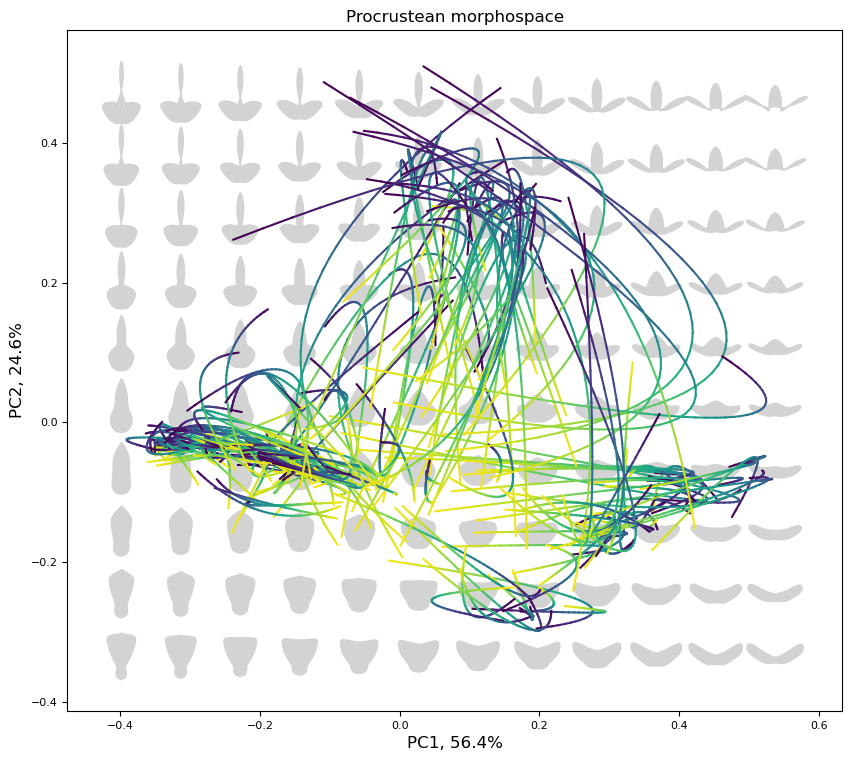

In [11]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 12 # set number of PC1 intervals
numPC2 = 10 # set number of PC2 intervals
hue = "morphotype" # select the factor to color by
s = 0.25 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 1 # alpha of inverse eigenleaf
pt_size = 20 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   


for i in range(len(leaf_model_arr)):

    curr_model = leaf_model_arr[i]

    for j in range(intervals-1): # for each interval (intervals-1), from tip to base

        curr_lf = curr_model[j] # get current lf
        next_lf = curr_model[j+1] # get current lf

        curr_pca = pca.transform(np.reshape(curr_lf, (1,-1))) # project values onto PCA
        next_pca = pca.transform(np.reshape(next_lf, (1,-1)))

        plt.plot([curr_pca[0][0],next_pca[0][0]],
                 [curr_pca[0][1],next_pca[0][1]],
                 c=rgba_values[j]
                )




#plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(False)
plt.gca().set_axisbelow(True)
plt.title(title)


### Comparing dimension reduction techniques 

We compare different dimension reduction and visualiztion techniques with respect to separating morphotypes using 1) individual leaf data and 2) developmental models. For each type of data, arrays were first flattened to their respective individual units, either leaves or models. Then, leaves and models were compared by T-distributed Stochastic Neighbor Embedding (t-SNE, [van der Maaten and Hinton, 2008](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbcl)), Uniform Manifold Approximation and Projection (UMAP, [McInnes, Healy, and Melville, 2018](https://arxiv.org/abs/1802.03426)), and Potential of Heat-diffusion for Affinity-based Trajectory Embedding (PHATE, [Moon et al., 2019](https://www.nature.com/articles/s41587-019-0336-3)).

In [12]:
# flatten the leaf model data to each model
flat_leaf_models = np.reshape(leaf_model_arr,
                             (np.shape(leaf_model_arr)[0],
                              np.shape(leaf_model_arr)[1]*np.shape(leaf_model_arr)[2]*np.shape(leaf_model_arr)[3])
                            )
############
### TSNE ###
############

tsne_leaves = TSNE(n_components=2, random_state=42).fit_transform(flat_arr) 
tsne_model = TSNE(n_components=2, random_state=42).fit_transform(flat_leaf_models) 

mdata["tsne1"] = tsne_leaves[:,0]
mdata["tsne2"] = tsne_leaves[:,1]

model_df["tsne1"] = tsne_model[:,0]
model_df["tsne2"] = tsne_model[:,1]

############
### UMAP ###
############

reducer = umap.UMAP(random_state=42)
reducer.fit(flat_arr)
umap_leaves_embedding = reducer.transform(flat_arr)

reducer = umap.UMAP(random_state=42)
reducer.fit(flat_leaf_models)
umap_model_embedding = reducer.transform(flat_leaf_models)

mdata["umap1"] = umap_leaves_embedding[:,0]
mdata["umap2"] = umap_leaves_embedding[:,1]

model_df["umap1"] = umap_model_embedding[:,0]
model_df["umap2"] = umap_model_embedding[:,1]


phate_operator = phate.PHATE()
phate_leaves = phate_operator.fit_transform(flat_arr)
phate_models = phate_operator.fit_transform(flat_leaf_models)

mdata["phate1"] = phate_leaves[:,0]
mdata["phate2"] = phate_leaves[:,1]

model_df["phate1"] = phate_models[:,0]
model_df["phate2"] = phate_models[:,1]

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Calculating PHATE...
  Running PHATE on 3244 observations and 198 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.55 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.70 seconds.
  Calculated landmark operator in 2.08 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 1.82 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.65 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.74 seconds.
Calculated PHATE in 6.86 seconds.
Calculating PHATE...
  Running PHATE on 226 observations and 7920 variables.
  Calculating graph and diffusion oper

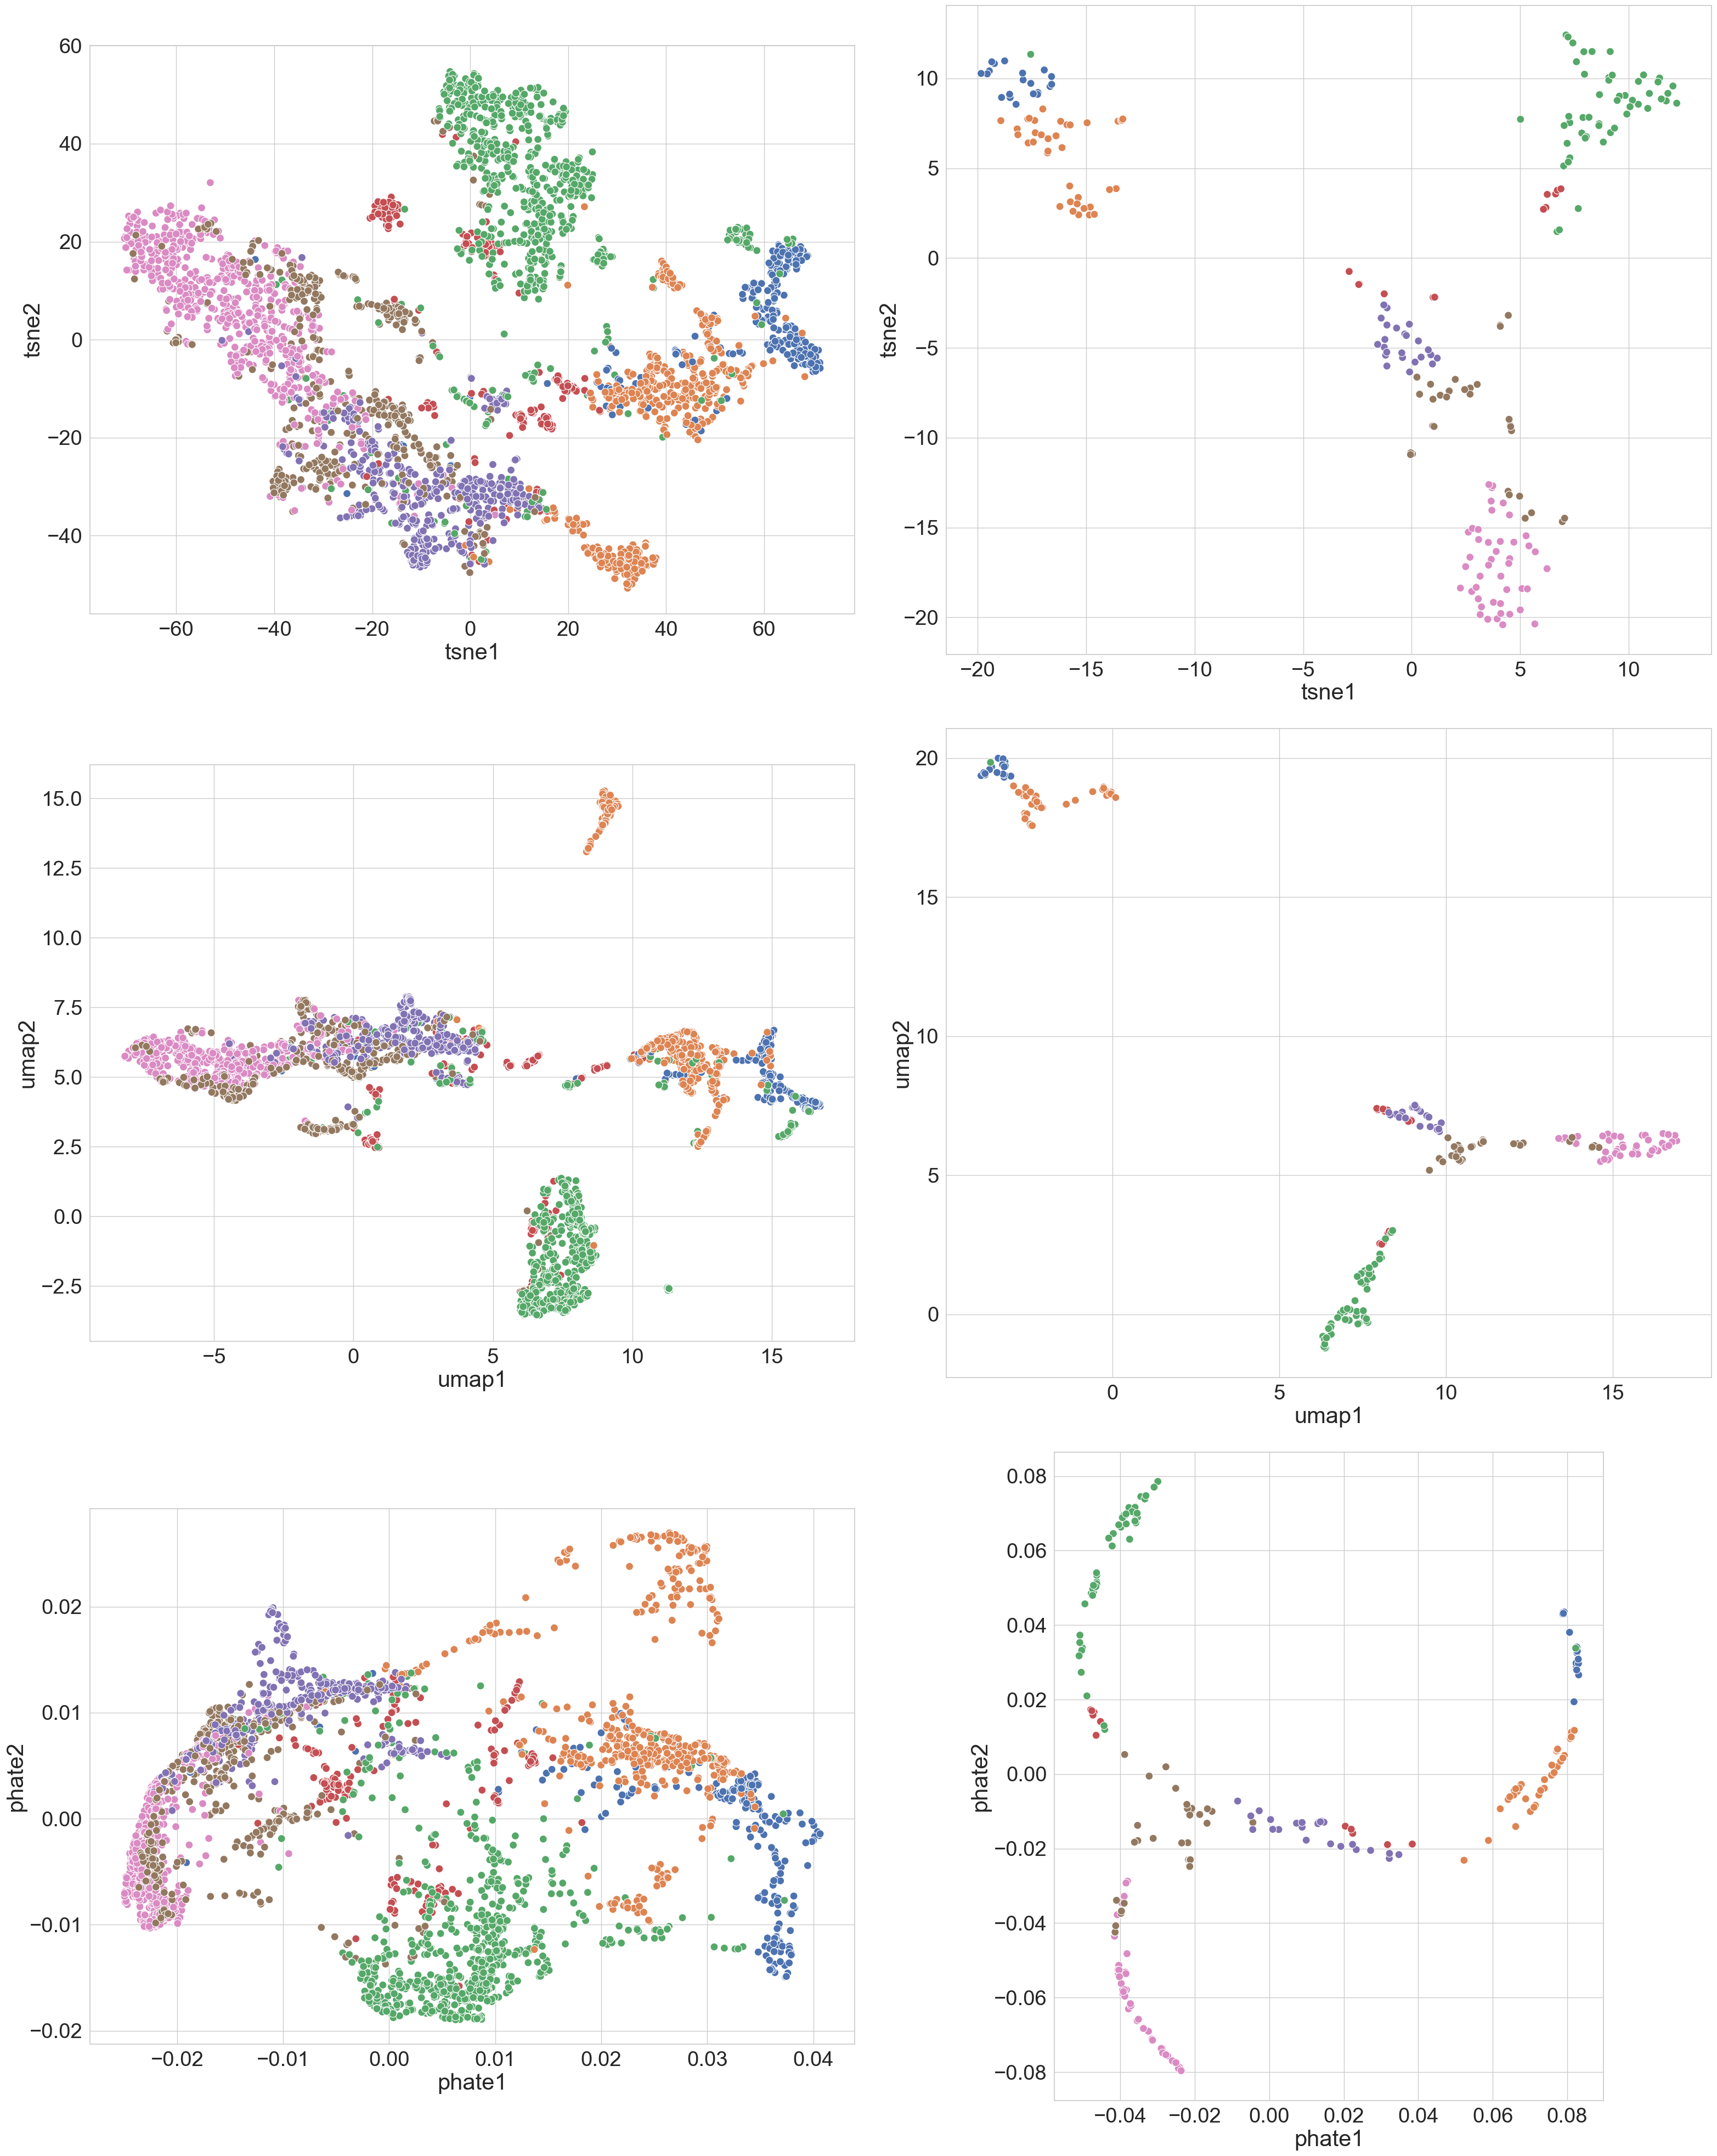

In [33]:
plt.figure(figsize=(32,40))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
pt_size=100

plt.subplot(3,2,1)
sns.scatterplot(data=mdata, x="tsne1", y="tsne2", 
                hue="morphotype",
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, legend=False
               )
plt.gca().set_aspect("equal")

plt.subplot(3,2,2)
sns.scatterplot(data=model_df, x="tsne1", y="tsne2", 
                hue="morpho",
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, legend=False
               )


plt.subplot(3,2,3)
sns.scatterplot(data=mdata, x="umap1", y="umap2", 
                hue="morphotype",
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, legend=False
               )
plt.gca().set_aspect("equal")

plt.subplot(3,2,4)
sns.scatterplot(data=model_df, x="umap1", y="umap2", 
                hue="morpho",
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, legend=False
               )

plt.subplot(3,2,5)
sns.scatterplot(data=mdata, x="phate1", y="phate2", 
                hue="morphotype",
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, legend=False
               )
plt.gca().set_aspect("equal")

plt.subplot(3,2,6)
sns.scatterplot(data=model_df, x="phate1", y="phate2", 
                hue="morpho",
                hue_order = [' A',' B',' C',' D',' E',' F',' G'],
                s=pt_size, legend=False
               )
plt.gca().set_aspect("equal")

plt.tight_layout()